## Train ResNets

### created by Yuying Liu, 04/30/2020

This script is a template for training neural network time-steppers for different systems and different time scales. To reproduce the results in the paper, one needs to obtain all 11 neural network models for each nonlinear system under study. For setup details, please refer to Table 2 in the paper.

In [1]:
import os
import sys
import torch
import numpy as np

import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [2]:
# adjustables

t = np.linspace(0, 8*np.pi, 500)
k = 0                         # model index: should be in {0, 2, ..., 10}
dt = t[1] - t[0]#0.01# 0.0005                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'toy1'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epoch = 100000            # the maximum training epoch 
batch_size = 320              # training batch size
arch = [4, 128, 128, 128, 4]  # architecture of the neural network

In [3]:
# paths
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
n_forward = 5
step_size = 2**k

In [4]:
# load data
data = np.load(os.path.join(data_dir, "train_data.npy"))#inputs_2x2.npy"))#'train_noise{}.npy'.format(noise)))

# print(np.load("../../data/Hyperbolic/train_noise0.0.npy").shape)
# data = np.expand_dims(data, 1)
train_data = data[:75]
val_data = data[75:90]
test_data = data[90:]
# val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
# test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)
n_train = train_data.shape[0]
n_val = val_data.shape[0]
n_test = test_data.shape[0]
print(n_train)
print(n_val)
print(n_test)

print(train_data[0,:,:])

print("step_size*n_forward+1 = ", step_size*n_forward+1)
print("step_size*n_forward+1 = ", step_size*n_forward+1)
# create dataset object
dataset = net.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)

(75, 500, 4)
(15, 500, 4)
(10, 500, 4)
75
15
10
[[1.65509105 1.73043919 1.58637822 1.65509105]
 [1.65484369 1.73016787 1.58615255 1.65484369]
 [1.65410161 1.72935414 1.58547592 1.65410161]
 ...
 [1.65410161 1.72935414 1.58547592 1.65410161]
 [1.65484369 1.73016787 1.58615255 1.65484369]
 [1.65509105 1.73043919 1.58637822 1.65509105]]
step_size*n_forward+1 =  6
step_size*n_forward+1 =  6


C:\Users\16kat\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


IndexError: index 75 is out of bounds for axis 0 with size 75

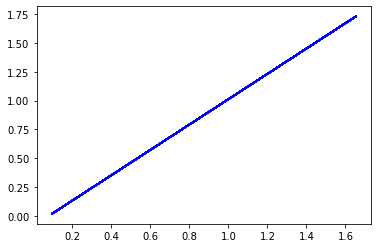

In [5]:
for i in range(100):
    plt.plot(train_data[i,:,0], train_data[i,:,1], 'b')

In [7]:
for k in [ 2, 3, 4, 5]:
    print("k = ", k)
    step_size = 2**k
    dataset = net.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)
    print(dataset.train_x.shape)
    model_name = 'model_D{}_noise{}_0.pt'.format(step_size, noise)

    # create/load model object
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = torch.load(os.path.join(model_dir, model_name), map_location=device)
        model.device = device
    except:
        print('create model {} ...'.format(model_name))
        model = net.ResNet(arch=arch, dt=dt, step_size=step_size)

    # training
    model.train_net(dataset, max_epoch=30000, batch_size=batch_size, lr=lr,
                    model_path=os.path.join(model_dir, model_name))

k =  2
torch.Size([75, 4])
create model model_D4_noise0.0_0.pt ...
self.n_dim=  4
dataset.n_dim =  4
epoch 1000, training loss 0.02707066386938095, validation loss 0.016816485673189163
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.02314790152013302, validation loss 0.017457518726587296
epoch 3000, training loss 0.01839704066514969, validation loss 0.01554041262716055
(--> new model saved @ epoch 3000)
epoch 4000, training loss 0.025591034442186356, validation loss 0.01909712888300419
epoch 5000, training loss 0.029506918042898178, validation loss 0.027479693293571472
epoch 6000, training loss 0.02377093955874443, validation loss 0.016731631010770798
epoch 7000, training loss 0.019063271582126617, validation loss 0.017341965809464455
epoch 8000, training loss 0.019028738141059875, validation loss 0.019361726939678192
epoch 9000, training loss 0.015002816915512085, validation loss 0.01491491962224245
(--> new model saved @ epoch 9000)
epoch 10000, training loss 0.0109026

epoch 26000, training loss 0.1540994644165039, validation loss 0.10081202536821365
epoch 27000, training loss 0.14612990617752075, validation loss 0.13641373813152313
epoch 28000, training loss 0.14703361690044403, validation loss 0.12155406922101974
epoch 29000, training loss 0.14932742714881897, validation loss 0.13731727004051208
epoch 30000, training loss 0.09523860365152359, validation loss 0.0704936757683754
k =  5
torch.Size([75, 4])
create model model_D32_noise0.0_0.pt ...
self.n_dim=  4
dataset.n_dim =  4
epoch 1000, training loss 0.15984828770160675, validation loss 0.1325707584619522
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.13462845981121063, validation loss 0.09043938666582108
(--> new model saved @ epoch 2000)
epoch 3000, training loss 0.11945127695798874, validation loss 0.10309130698442459
epoch 4000, training loss 0.11737742274999619, validation loss 0.08436296880245209
(--> new model saved @ epoch 4000)
epoch 5000, training loss 0.1641658395528793

In [ ]:
 

.